<a href="https://colab.research.google.com/github/Ankit-exe/Anime-Character-Generator/blob/main/Anime_character.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from PIL import Image
import cv2

import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
from google.colab import files
from torch.utils.data import Dataset, DataLoader

In [2]:
# Setting seed
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
  torch.cuda.manual_seed_all(42)

In [3]:
# Configuration
IMAGE_SIZE = 64
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EPOCHS = 50
NOISE_DIM = 100
num_examples_to_generate = 16
LEARNING_RATE = 0.0002
GENERATOR_LR = 0.0005
DISCRIMINATOR_LR = 0.0002
SAMPLE_INTERVAL = 5

# It is good to have higher lr for the generator than discriminator because we dont want out discriminator to be so good

In [4]:
# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print(f"GPU NAME: {torch.cuda.get_device_name(0)}")

GPU NAME: Tesla T4


In [5]:
!pip install opendatasets

In [6]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/splcher/animefacedataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ankitexe
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:03<00:00, 116MB/s] 


In [7]:
# DATASET PATH
DATASET_PATH = "animefacedataset/images"

if not os.path.exists(DATASET_PATH):
  print("Dataset not found")
else:
   print("dataset exists")

dataset exists


In [8]:
image_files = []
valid_extensions = ('.jpg','.jpeg','.png','.bmp')

for file in os.listdir(DATASET_PATH):
  if file.lower().endswith(valid_extensions):
    image_files.append(file)

print(f"Total images: {len(image_files)}")
print(f"Sample files:{image_files[:5]}")

Total images: 63565
Sample files:['25232_2009.jpg', '194_2000.jpg', '24058_2008.jpg', '16842_2007.jpg', '19462_2007.jpg']


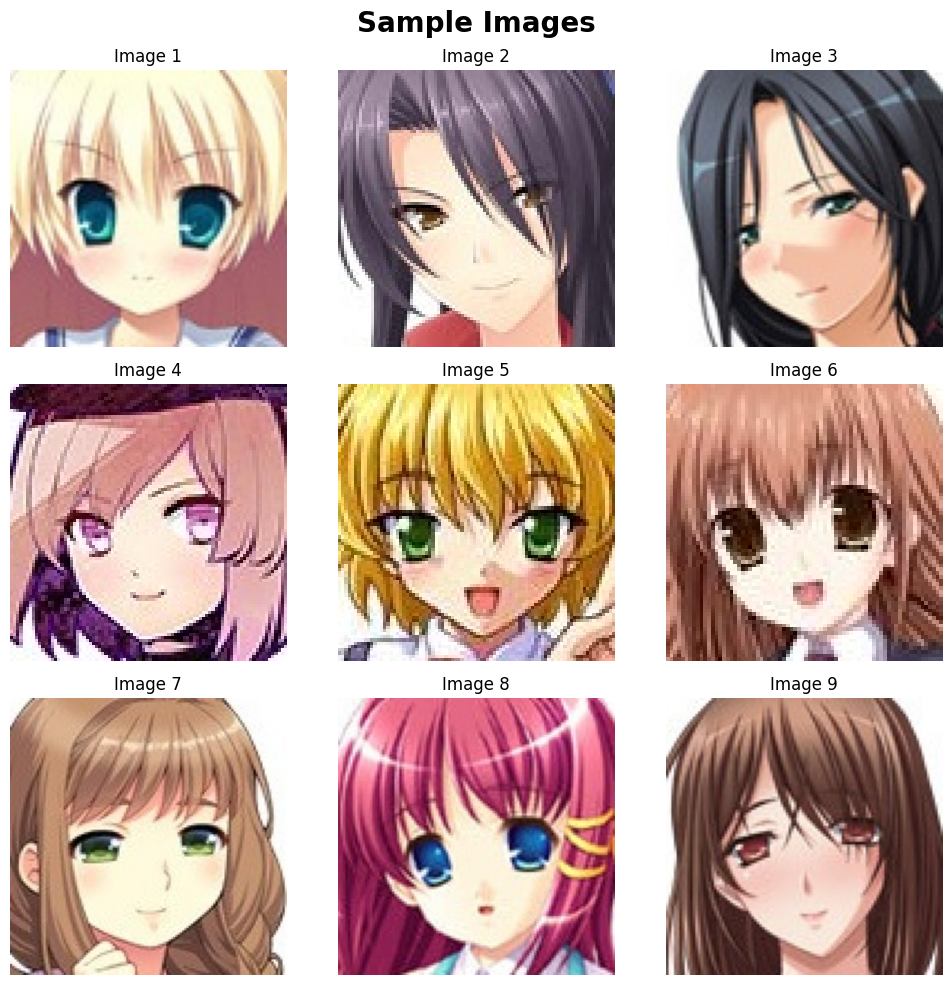

In [9]:
# Visualizing the Dataset

def display_sample_images(image_files,DATASET_PATH,num_samples = 9):
  fig, axes = plt.subplots(3,3,figsize=(10,10))
  fig.suptitle("Sample Images",fontsize=20, fontweight='bold')

  sample_files = np.random.choice(image_files,num_samples,replace=False)

  for i, ax in enumerate(axes.flatten()):
    img_path = os.path.join(DATASET_PATH,sample_files[i])
    try:
      img = Image.open(img_path)
      ax.imshow(img)
      ax.set_title(f"Image {i+1}")

    except Exception as e:
      print(f"Error loading image {img_path}: {e}")
      continue

    ax.axis('off')

  plt.tight_layout()
  plt.show()

display_sample_images(image_files,DATASET_PATH)


In [10]:
# Image properties

def analyze_images(image_files,DATASET_PATH,sample_size = 1000):
  sample_files = np.random.choice(image_files,min(sample_size,len(image_files)),replace=False)

  widths, heights, channels = [],[],[]
  file_sizes = []

  print("Calcuating image properties...")

  for file in tqdm(sample_files[:100]):
    try:
      img_path = os.path.join(DATASET_PATH,file)
      img = Image.open(img_path)

      width, height = img.size
      channel = len(img.getbands())
      file_size = os.path.getsize(img_path)

      widths.append(width)
      heights.append(height)
      channels.append(channel)
      file_sizes.append(file_size)

    except Exception as e:
      print(f"Error loading image {img_path}: {e}")
      continue

  return {
    'width':widths,
    'height':heights,
    'channel':channels,
    'file_size':file_sizes
  }

image_stats = analyze_images(image_files,DATASET_PATH)

Calcuating image properties...


100%|██████████| 100/100 [00:00<00:00, 2002.39it/s]


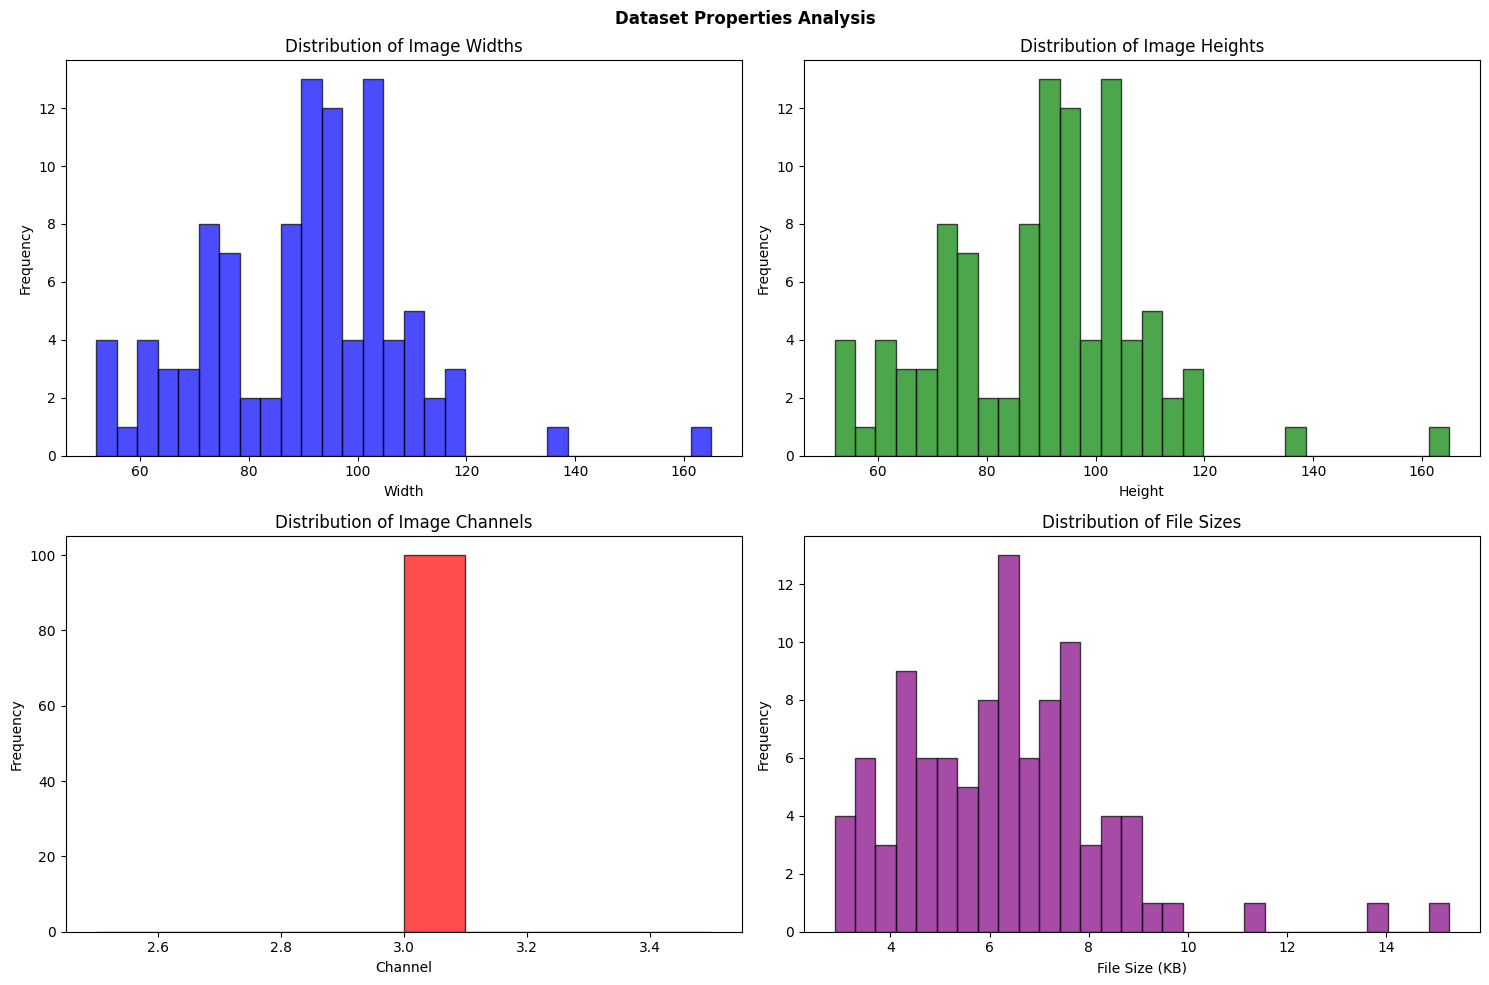

In [25]:
fig ,axes = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("Dataset Properties Analysis", fontweight='bold')

axes[0,0].hist(image_stats['width'],bins=30,alpha =0.7 , color='blue', edgecolor='black')
axes[0,0].set_xlabel('Width')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Image Widths')

axes[0,1].hist(image_stats['height'],bins=30,alpha =0.7 , color='green', edgecolor='black')
axes[0,1].set_xlabel('Height')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Image Heights')

axes[1,0].hist(image_stats['channel'],bins=10  ,alpha =0.7 , color='red', edgecolor='black')
axes[1,0].set_xlabel('Channel')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Image Channels')

axes[1,1].hist([size/1024 for size in image_stats['file_size']], bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1,1].set_xlabel('File Size (KB)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of File Sizes')

plt.tight_layout()
plt.show()

In [12]:
# Print statistics

print(f"Image Statistics:")
print(f"Average width: {np.mean(image_stats['width']):.2f} \xb1 {np.std(image_stats['width']):.2f}")
print(f"Average height: {np.mean(image_stats['height']):.2f} \xb1 {np.std(image_stats['height']):.2f}")
print(f"Number of channels: {max(set(image_stats['channel']))}")
print(f"Average file size: {np.mean(image_stats['file_size'])/1000:.2f}KB")

Image Statistics:
Average width: 89.96 ± 18.47
Average height: 89.96 ± 18.47
Number of channels: 3
Average file size: 6.43KB


In [26]:
# Data Pre-Processing Pipeline

img_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])

class AnimeDataset(Dataset):
  def __init__(self,data_path,transform=None):
    self.data_path = data_path
    self.transform = transform
    self.image_files = [f for f in os.listdir(data_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self,idx):
    img_path = os.path.join(self.data_path,self.image_files[idx])
    img = Image.open(img_path).convert('RGB')

    if self.transform:
      img = self.transform(img)
    return img

anime_dataset = AnimeDataset(DATASET_PATH,img_transforms)
print('Dataset Created')

Dataset Created


In [27]:
train_dataloader = DataLoader(anime_dataset, batch_size=BATCH_SIZE,shuffle=True,num_workers=2)

dataset_size = len(anime_dataset)
print(f"Total images in dataset: {dataset_size}")
print(f"Batches per epoch: {len(train_dataloader)}")
print(f"Image shape: {IMAGE_SIZE,IMAGE_SIZE}")
print(f"Batch size:{BATCH_SIZE}")

Total images in dataset: 63565
Batches per epoch: 994
Image shape: (64, 64)
Batch size:64


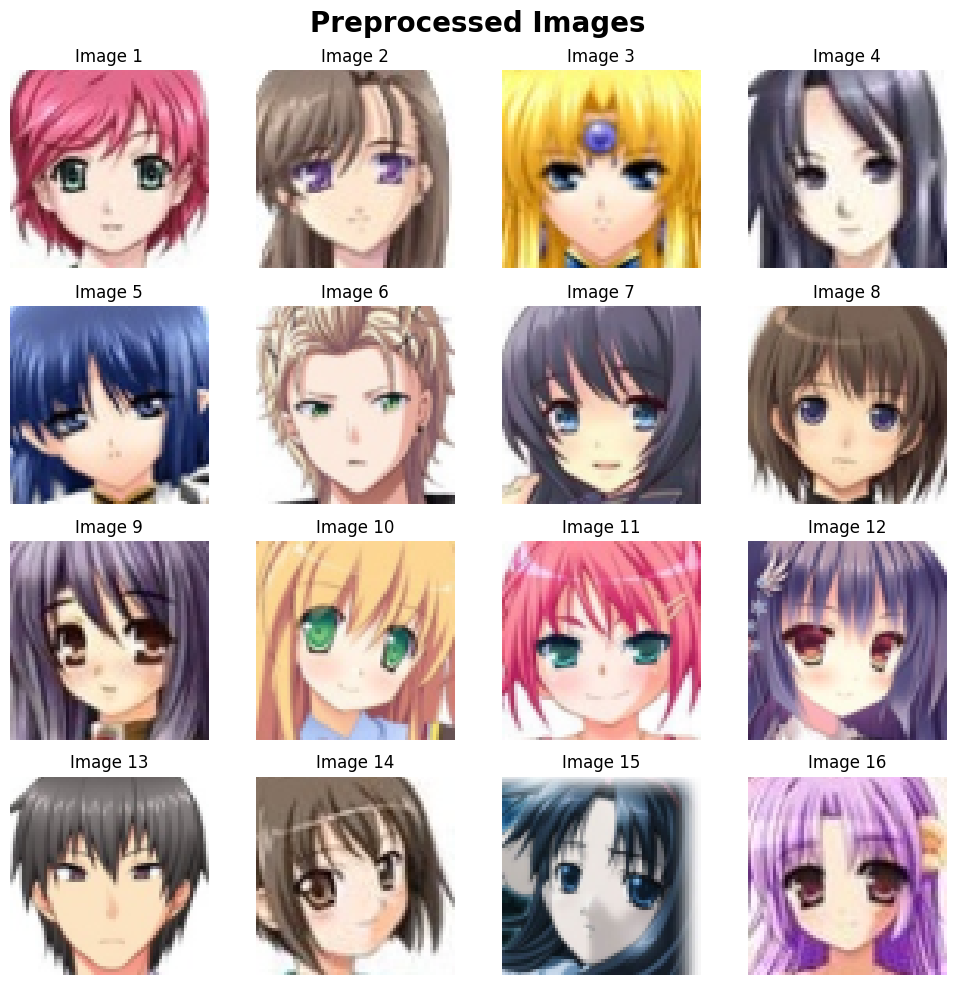

In [28]:
# Visualize PreProcessed Data

def show_preprocessed_batch(dataloader,num_images = 16):
  batch = next(iter(dataloader))
  batch = batch.to(device if device.type!= 'cuda' else 'cpu')
  fig , axes = plt.subplots(4,4,figsize=(10,10))
  fig.suptitle("Preprocessed Images",fontsize=20, fontweight='bold')

  for i, ax in enumerate(axes.flat):
    if i<num_images and i<batch.size(0):
      img = batch[i] * 0.5 + 0.5
      img = torch.clamp(img,0.0,1.0)
      ax.imshow(img.cpu().permute(1,2,0).numpy())
      ax.set_title(f"Image {i+1}")
      ax.axis('off')

  plt.tight_layout()
  plt.show()

show_preprocessed_batch(train_dataloader)

In [29]:
# Generator

class Generator(nn.Module):
  def __init__(self, latent_dim=100,img_channels=3, feature_maps=64):
    super(Generator,self).__init__()

    self.main = nn.Sequential(
        nn.ConvTranspose2d(latent_dim,feature_maps*8,4,1,0,bias=False),
        nn.BatchNorm2d(feature_maps*8),
        nn.ReLU(True),

        nn.ConvTranspose2d(feature_maps*8,feature_maps*4,4,2,1,bias=False),
        nn.BatchNorm2d(feature_maps*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(feature_maps*4,feature_maps*2,4,2,1,bias=False),
        nn.BatchNorm2d(feature_maps*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(feature_maps*2,feature_maps,4,2,1,bias=False),
        nn.BatchNorm2d(feature_maps),
        nn.ReLU(True),

        nn.ConvTranspose2d(feature_maps,img_channels,4,2,1,bias=False),
        nn.Tanh()
    )

  def forward(self,x):
    return self.main(x)

generator = Generator(NOISE_DIM).to(device)

print("Generator Architecture")
print(generator)

Generator Architecture
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)


In [30]:
# Discriminator

class Discriminator(nn.Module):
  def __init__(self,img_channels=3,feature_maps=64):
    super(Discriminator,self).__init__()

    self.main = nn.Sequential(
      nn.Conv2d(img_channels,feature_maps,4,2,1,bias=False),
      nn.LeakyReLU(0.2,inplace=True),

      nn.Conv2d(feature_maps,feature_maps*2,4,2,1,bias=False),
      nn.BatchNorm2d(feature_maps*2),
      nn.LeakyReLU(0.2,inplace=True),

      nn.Conv2d(feature_maps*2,feature_maps*4,4,2,1,bias=False),
      nn.BatchNorm2d(feature_maps*4),
      nn.LeakyReLU(0.2,inplace=True),

      nn.Conv2d(feature_maps*4,feature_maps*8,4,2,1,bias=False),
      nn.BatchNorm2d(feature_maps*8),
      nn.LeakyReLU(0.2,inplace=True),

      nn.Conv2d(feature_maps*8,1,4,1,0,bias=False),
      nn.Sigmoid()
  )

  def forward(self,x):
    return self.main(x).view(-1, 1).squeeze(1)

discriminator = Discriminator().to(device)

print("Discriminator Architecture")
print(discriminator)

Discriminator Architecture
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [31]:
# Loss Function Optimizer

def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data,0.0,0.02)

  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data,1.0,0.02)
    nn.init.constant_(m.bias.data,0)

generator.apply(weights_init)
discriminator.apply(weights_init)

# Loss Function

criterion = nn.BCELoss()

# Optimizers
generator_optimizer = optim.Adam(generator.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))

print("Model initialized successfully!")
print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")

print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")

Model initialized successfully!
Generator parameters: 3,576,704
Discriminator parameters: 2,765,568


In [32]:
# Training setup & Checkpoints

checkpoint_dir = './training_checkpoints'
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
  print("Checkpoint directory created")

fixed_noise = torch.randn(num_examples_to_generate,NOISE_DIM,1,1,device=device)

In [33]:
# Training Function

def generate_and_save_img(model_G,epoch,test_input_noise):
  model_G.eval()

  with torch.no_grad():
    predictions = model_G(test_input_noise).cpu()
  model_G.train()

  fig = plt.figure(figsize=(8,8))
  fig.suptitle(f"Epoch {epoch}",fontsize=20, fontweight='bold')

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    img = predictions[i]*0.5+0.5
    img = torch.clamp(img,0.0,1.0)
    plt.imshow(img.permute(1,2,0).numpy())
    plt.axis('off')

  plt.tight_layout()
  plt.show()

In [34]:
def generate_samples(generator,latent_dim,device,num_samples=16):
  generator.eval()
  with torch.no_grad():
    noise = torch.randn(num_samples,latent_dim,1,1,device=device)
    fake_images = generator(noise)

    fake_images = (fake_images + 1)/2
    fake_images = torch.clamp(fake_images,0,1)

    fig , axes = plt.subplots(4,4,figsize=(10,10))
    fig.suptitle("Generated Images",fontsize=20, fontweight='bold')

    for i in range(num_samples):
            row, col = i // 4, i % 4
            img = fake_images[i].cpu().permute(1, 2, 0)
            axes[row, col].imshow(img)
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

  generator.train()

In [35]:
def train_gan(dataloader, generator, discriminator, generator_optimizer, discriminator_optimizer, criterion, noise_dim, fixed_noise, device):
    d_losses = []
    g_losses = []
    d_losses_iter = []
    g_losses_iter = []

    torch.autograd.set_detect_anomaly(True)

    print("Starting Training...")
    print(f"Training for {EPOCHS} epochs with {len(dataloader)} batches per epoch")

    for epoch in range(EPOCHS):
        epoch_g_loss = 0
        epoch_d_loss = 0
        num_batches = 0

        # Progress bar for current epoch
        pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}')

        for i, real_images in enumerate(pbar):
            current_batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Labels
            real_labels = torch.ones(current_batch_size, device=device)
            fake_labels = torch.zeros(current_batch_size, device=device)

            # Train with real images
            discriminator.zero_grad()
            output_real = discriminator(real_images)
            loss_real = criterion(output_real, real_labels)

            # Train with fake images
            noise = torch.randn(current_batch_size, noise_dim, 1, 1, device=device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach())
            loss_fake = criterion(output_fake, fake_labels)

            # Total discriminator loss
            loss_D = loss_real + loss_fake
            loss_D.backward()
            discriminator_optimizer.step()

            # Train Generator
            generator.zero_grad()
            output_fake = discriminator(fake_images)
            loss_G = criterion(output_fake, real_labels)
            loss_G.backward()
            generator_optimizer.step()

            # Accumulate batch losses
            epoch_d_loss += loss_D.item()
            epoch_g_loss += loss_G.item()
            num_batches += 1

            # Update progress bar
            pbar.set_postfix({
                'D_loss': f'{loss_D.item():.4f}',
                'G_loss': f'{loss_G.item():.4f}'
            })

        # Calculate average loss for the epoch
        avg_d_loss = epoch_d_loss / num_batches
        avg_g_loss = epoch_g_loss / num_batches

        # Store the average epoch loss
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)

        # # Print epoch summary
        avg_g_loss_iter = epoch_g_loss / len(dataloader)
        avg_d_loss_iter = epoch_d_loss / len(dataloader)
        d_losses_iter.append(avg_d_loss_iter)
        g_losses_iter.append(avg_g_loss_iter)

        print(f'Epoch [{epoch+1}/{EPOCHS}] - G_loss: {avg_g_loss:.4f}, D_loss: {avg_d_loss:.4f}')

        # Generate and display samples every SAMPLE_INTERVAL epochs
        if (epoch + 1) % SAMPLE_INTERVAL == 0:
            print(f"\n--- Generated Samples at Epoch {epoch+1} ---")
            generate_samples(generator, noise_dim, device)

            # Plot training losses
            if len(g_losses) > 10:
                plot_losses(g_losses_iter, d_losses_iter)

            print("-" * 50)

    print("Training completed!")
    return g_losses, d_losses

In [36]:
def plot_losses(g_losses, d_losses):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(g_losses, label='Generator Loss', color='blue')
    plt.plot(d_losses, label='Discriminator Loss', color='red')
    plt.title('Training Losses')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(g_losses[-100:], label='Generator Loss (Last 100)', color='blue')
    plt.plot(d_losses[-100:], label='Discriminator Loss (Last 100)', color='red')
    plt.title('Recent Training Losses')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.show()

Starting Anime Face GAN Training (PyTorch)!
Training with 63565 images for 50 epochs using PyTorch.
Starting Training...
Training for 50 epochs with 994 batches per epoch


Epoch 1/50: 100%|██████████| 994/994 [01:42<00:00,  9.73it/s, D_loss=0.8363, G_loss=4.1107]


Epoch [1/50] - G_loss: 7.1433, D_loss: 0.6484


Epoch 2/50: 100%|██████████| 994/994 [01:41<00:00,  9.83it/s, D_loss=0.5053, G_loss=6.0716]


Epoch [2/50] - G_loss: 6.0697, D_loss: 0.5402


Epoch 3/50: 100%|██████████| 994/994 [01:41<00:00,  9.84it/s, D_loss=0.1474, G_loss=5.1266]


Epoch [3/50] - G_loss: 6.1834, D_loss: 0.4408


Epoch 4/50: 100%|██████████| 994/994 [01:40<00:00,  9.89it/s, D_loss=0.1362, G_loss=4.1736]


Epoch [4/50] - G_loss: 5.7581, D_loss: 0.4590


Epoch 5/50: 100%|██████████| 994/994 [01:40<00:00,  9.91it/s, D_loss=0.3935, G_loss=2.8986]


Epoch [5/50] - G_loss: 5.2706, D_loss: 0.4504

--- Generated Samples at Epoch 5 ---


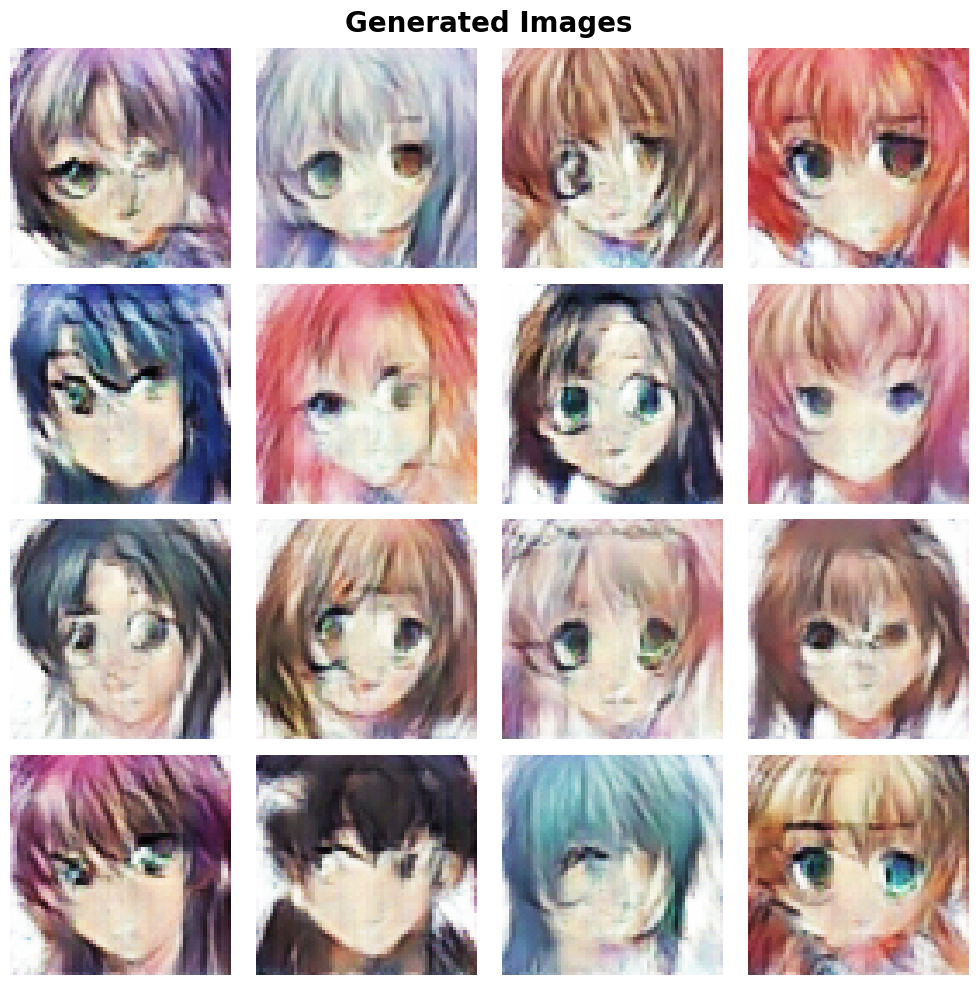

--------------------------------------------------


Epoch 6/50: 100%|██████████| 994/994 [01:44<00:00,  9.50it/s, D_loss=0.3511, G_loss=5.0971]


Epoch [6/50] - G_loss: 5.1410, D_loss: 0.4552


Epoch 7/50: 100%|██████████| 994/994 [01:46<00:00,  9.31it/s, D_loss=1.1767, G_loss=12.8413]


Epoch [7/50] - G_loss: 4.8876, D_loss: 0.4326


Epoch 8/50: 100%|██████████| 994/994 [01:43<00:00,  9.60it/s, D_loss=0.1120, G_loss=4.9585]


Epoch [8/50] - G_loss: 4.6392, D_loss: 0.4276


Epoch 9/50: 100%|██████████| 994/994 [01:43<00:00,  9.58it/s, D_loss=0.2453, G_loss=5.6783]


Epoch [9/50] - G_loss: 4.5133, D_loss: 0.4228


Epoch 10/50: 100%|██████████| 994/994 [01:43<00:00,  9.62it/s, D_loss=0.6165, G_loss=10.4352]


Epoch [10/50] - G_loss: 4.4223, D_loss: 0.3943

--- Generated Samples at Epoch 10 ---


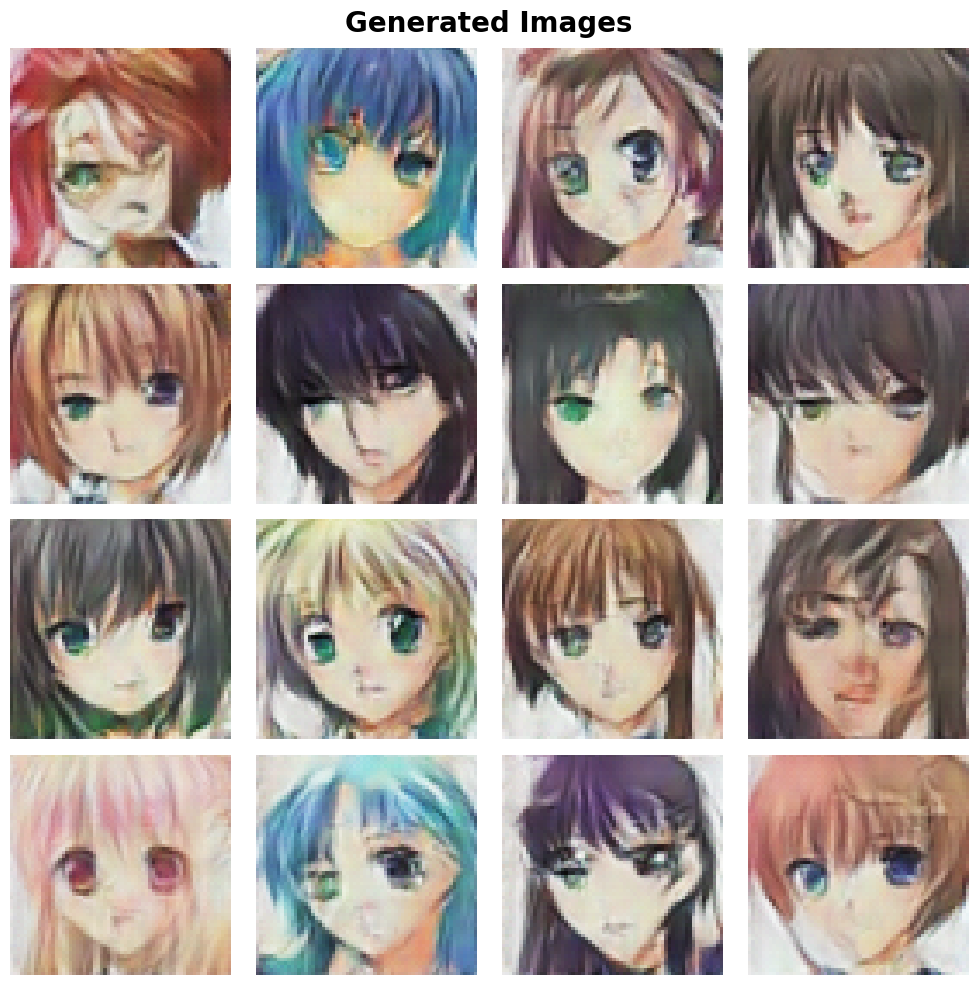

--------------------------------------------------


Epoch 11/50: 100%|██████████| 994/994 [01:46<00:00,  9.35it/s, D_loss=0.1636, G_loss=5.7638]


Epoch [11/50] - G_loss: 4.4241, D_loss: 0.4166


Epoch 12/50: 100%|██████████| 994/994 [01:45<00:00,  9.39it/s, D_loss=0.1194, G_loss=5.6301]


Epoch [12/50] - G_loss: 4.3367, D_loss: 0.3951


Epoch 13/50: 100%|██████████| 994/994 [01:46<00:00,  9.38it/s, D_loss=0.0305, G_loss=6.9724]


Epoch [13/50] - G_loss: 4.3300, D_loss: 0.4139


Epoch 14/50: 100%|██████████| 994/994 [01:46<00:00,  9.35it/s, D_loss=0.1319, G_loss=5.0303]


Epoch [14/50] - G_loss: 4.3310, D_loss: 0.4008


Epoch 15/50: 100%|██████████| 994/994 [01:46<00:00,  9.29it/s, D_loss=0.4747, G_loss=3.6785]


Epoch [15/50] - G_loss: 4.4334, D_loss: 0.3676

--- Generated Samples at Epoch 15 ---


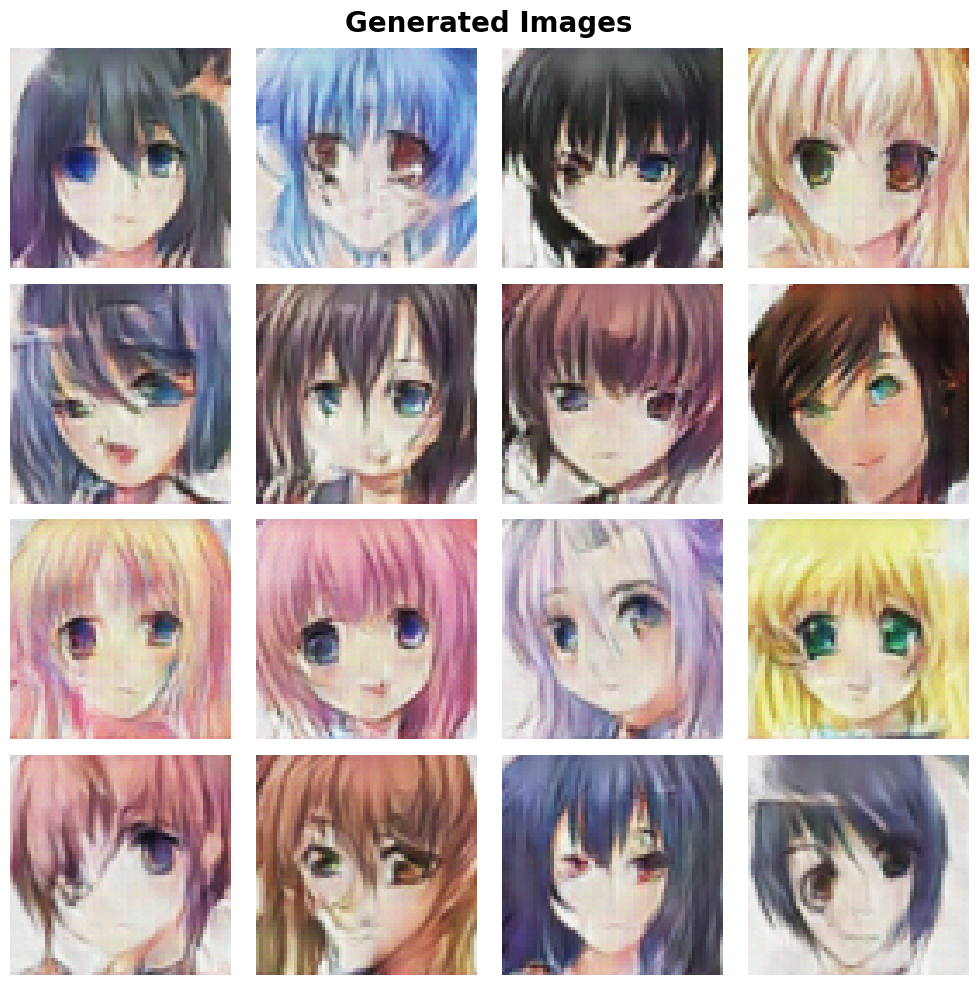

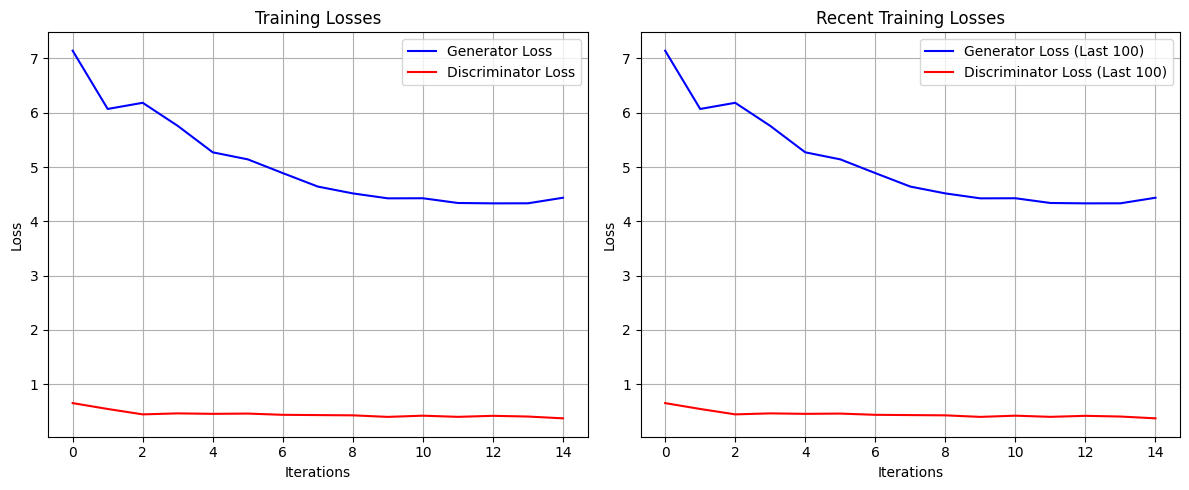

--------------------------------------------------


Epoch 16/50: 100%|██████████| 994/994 [01:49<00:00,  9.08it/s, D_loss=0.0243, G_loss=5.6299]


Epoch [16/50] - G_loss: 4.4760, D_loss: 0.3510


Epoch 17/50: 100%|██████████| 994/994 [01:50<00:00,  9.03it/s, D_loss=0.3256, G_loss=3.8815]


Epoch [17/50] - G_loss: 4.5240, D_loss: 0.3292


Epoch 18/50: 100%|██████████| 994/994 [01:51<00:00,  8.92it/s, D_loss=0.3980, G_loss=5.2985]


Epoch [18/50] - G_loss: 4.3808, D_loss: 0.4082


Epoch 19/50: 100%|██████████| 994/994 [01:49<00:00,  9.08it/s, D_loss=0.6893, G_loss=1.6190]


Epoch [19/50] - G_loss: 4.5583, D_loss: 0.3217


Epoch 20/50: 100%|██████████| 994/994 [01:50<00:00,  8.98it/s, D_loss=0.1905, G_loss=7.0779]


Epoch [20/50] - G_loss: 4.6175, D_loss: 0.3423

--- Generated Samples at Epoch 20 ---


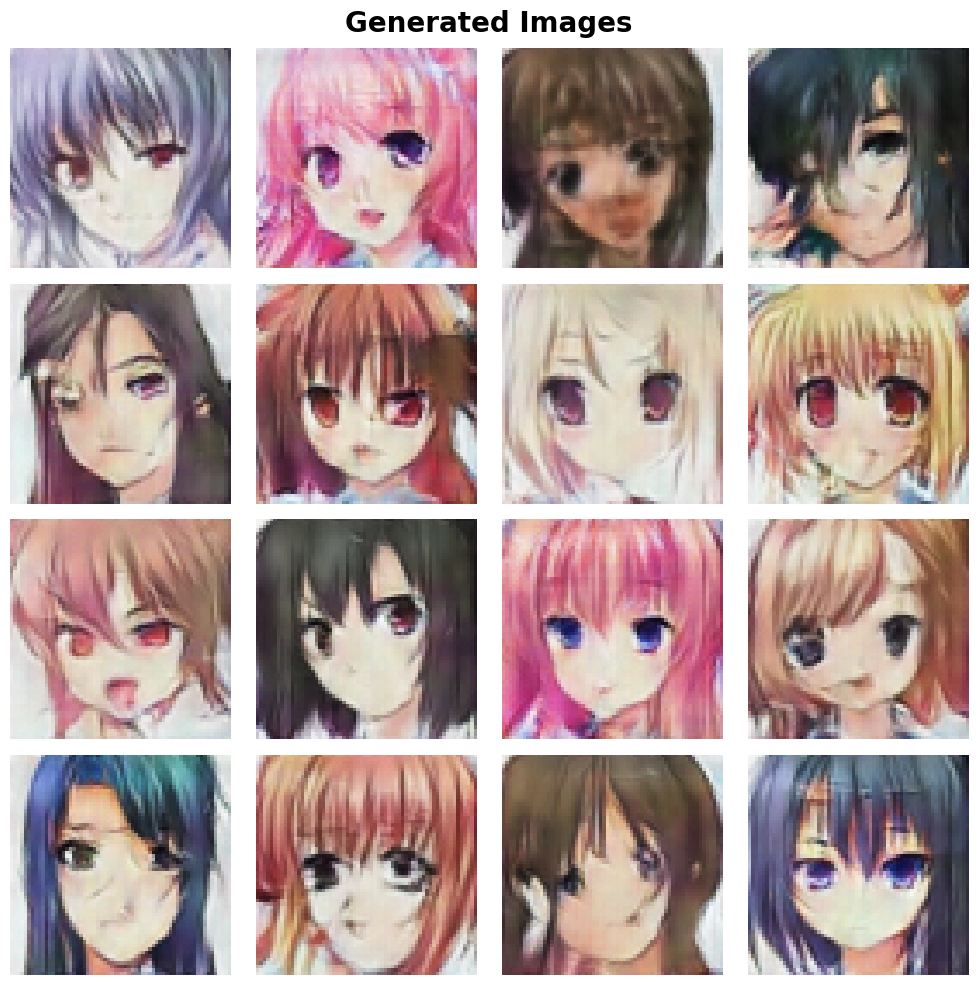

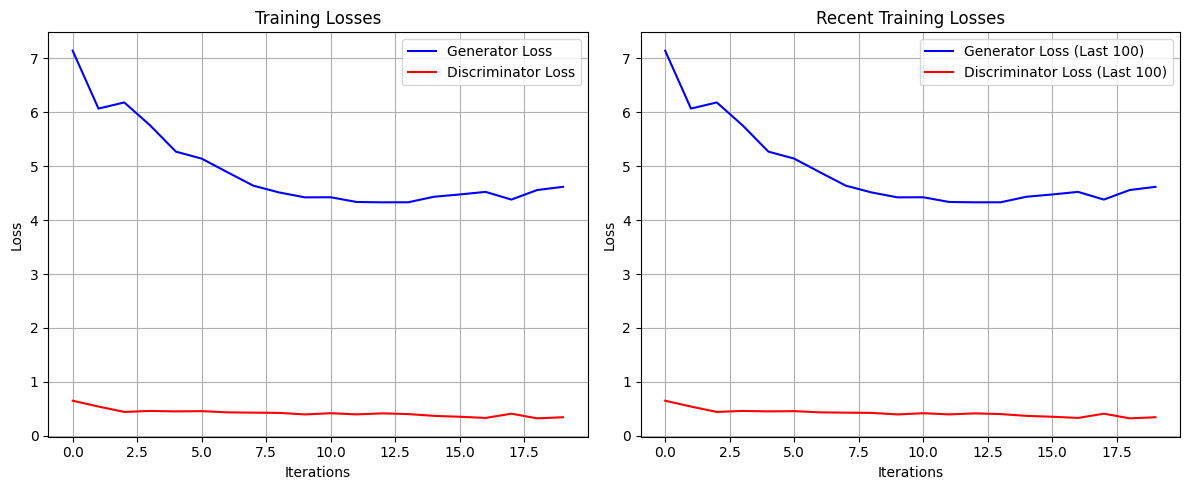

--------------------------------------------------


Epoch 21/50: 100%|██████████| 994/994 [01:54<00:00,  8.68it/s, D_loss=0.1986, G_loss=4.8008]


Epoch [21/50] - G_loss: 4.6829, D_loss: 0.3286


Epoch 22/50: 100%|██████████| 994/994 [02:15<00:00,  7.33it/s, D_loss=0.0667, G_loss=4.8096]


Epoch [22/50] - G_loss: 4.5361, D_loss: 0.3404


Epoch 23/50: 100%|██████████| 994/994 [02:11<00:00,  7.55it/s, D_loss=0.0768, G_loss=5.7700]


Epoch [23/50] - G_loss: 4.5264, D_loss: 0.2924


Epoch 24/50: 100%|██████████| 994/994 [02:02<00:00,  8.12it/s, D_loss=0.0535, G_loss=5.5078]


Epoch [24/50] - G_loss: 4.4550, D_loss: 0.4081


Epoch 25/50: 100%|██████████| 994/994 [01:57<00:00,  8.48it/s, D_loss=0.1142, G_loss=4.3894]


Epoch [25/50] - G_loss: 4.8920, D_loss: 0.2377

--- Generated Samples at Epoch 25 ---


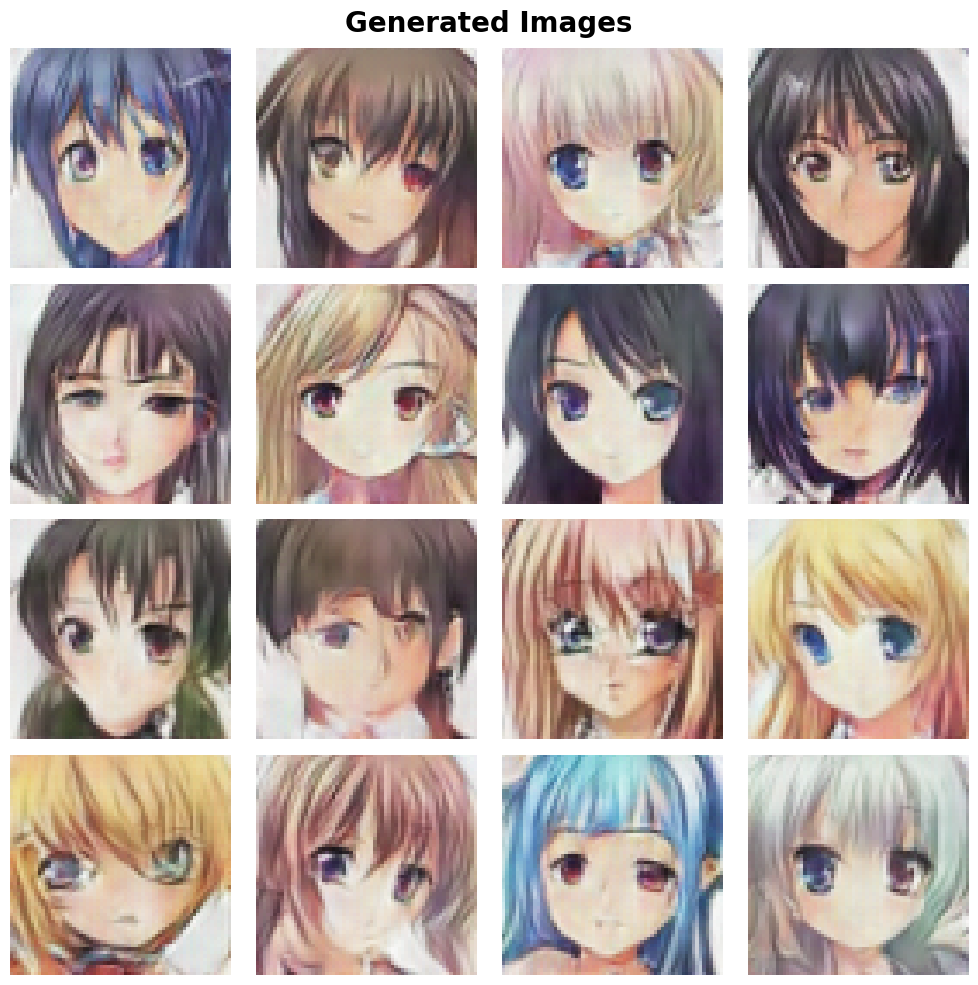

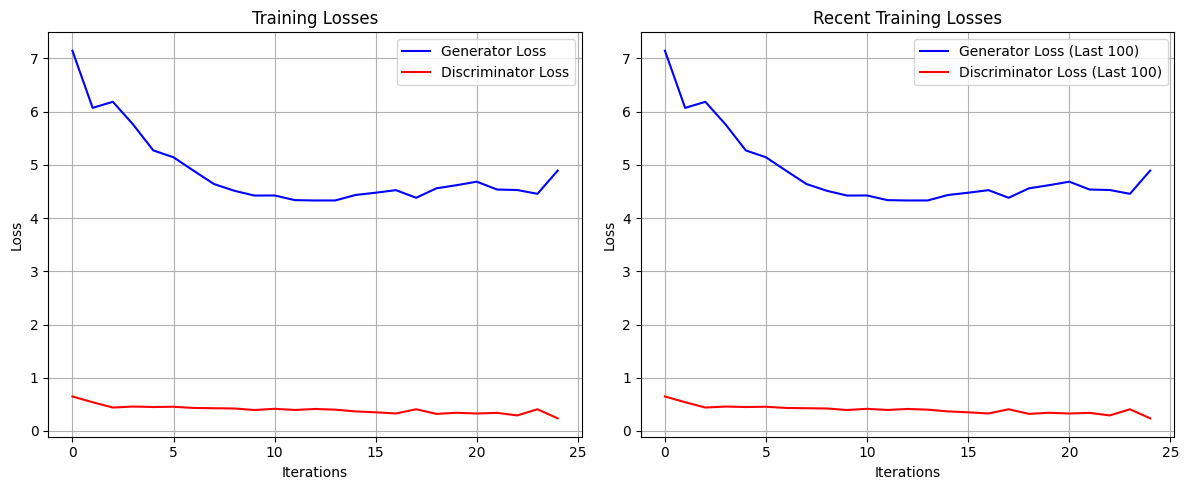

--------------------------------------------------


Epoch 26/50: 100%|██████████| 994/994 [02:00<00:00,  8.23it/s, D_loss=0.9437, G_loss=9.8047]


Epoch [26/50] - G_loss: 4.3970, D_loss: 0.4138


Epoch 27/50: 100%|██████████| 994/994 [02:02<00:00,  8.11it/s, D_loss=0.1158, G_loss=4.6086]


Epoch [27/50] - G_loss: 4.7070, D_loss: 0.2991


Epoch 28/50: 100%|██████████| 994/994 [02:08<00:00,  7.72it/s, D_loss=0.0742, G_loss=4.5775]


Epoch [28/50] - G_loss: 4.5788, D_loss: 0.3321


Epoch 29/50: 100%|██████████| 994/994 [02:11<00:00,  7.58it/s, D_loss=0.7863, G_loss=1.7179]


Epoch [29/50] - G_loss: 5.1864, D_loss: 0.1976


Epoch 30/50: 100%|██████████| 994/994 [02:08<00:00,  7.74it/s, D_loss=0.4976, G_loss=9.0079]


Epoch [30/50] - G_loss: 4.6752, D_loss: 0.3425

--- Generated Samples at Epoch 30 ---


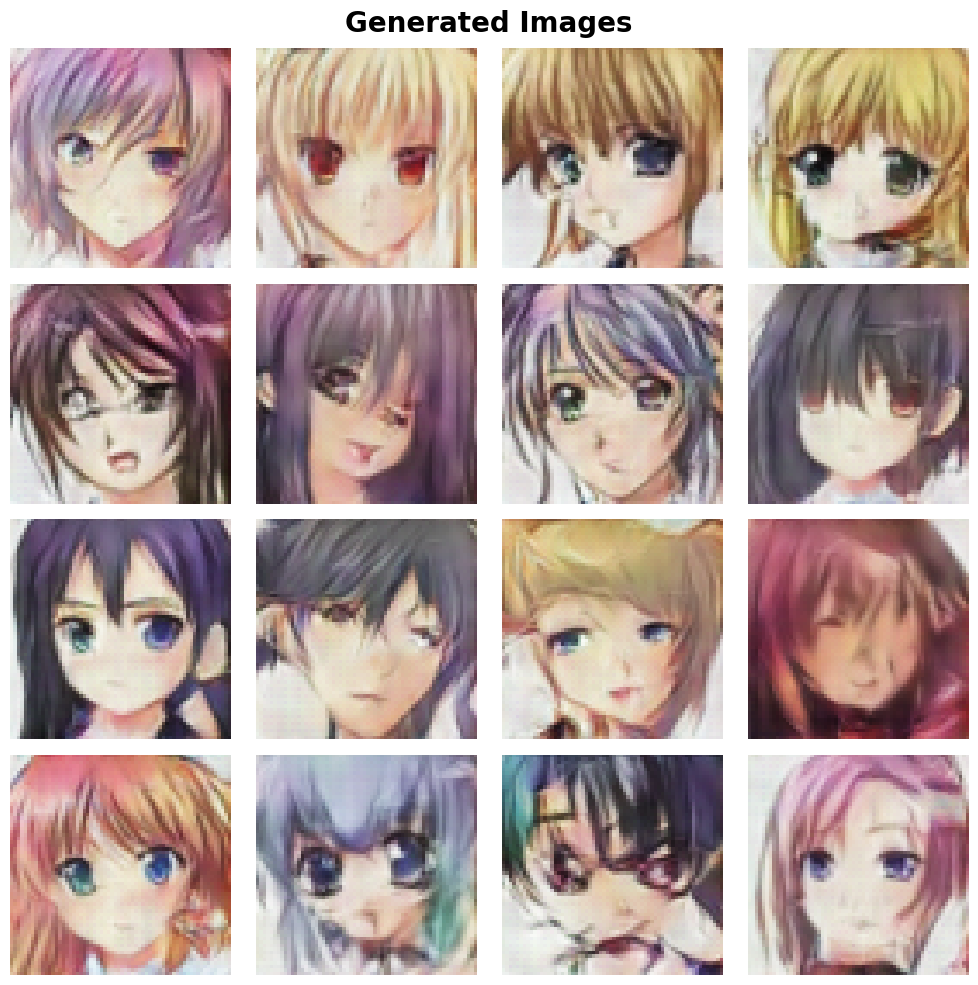

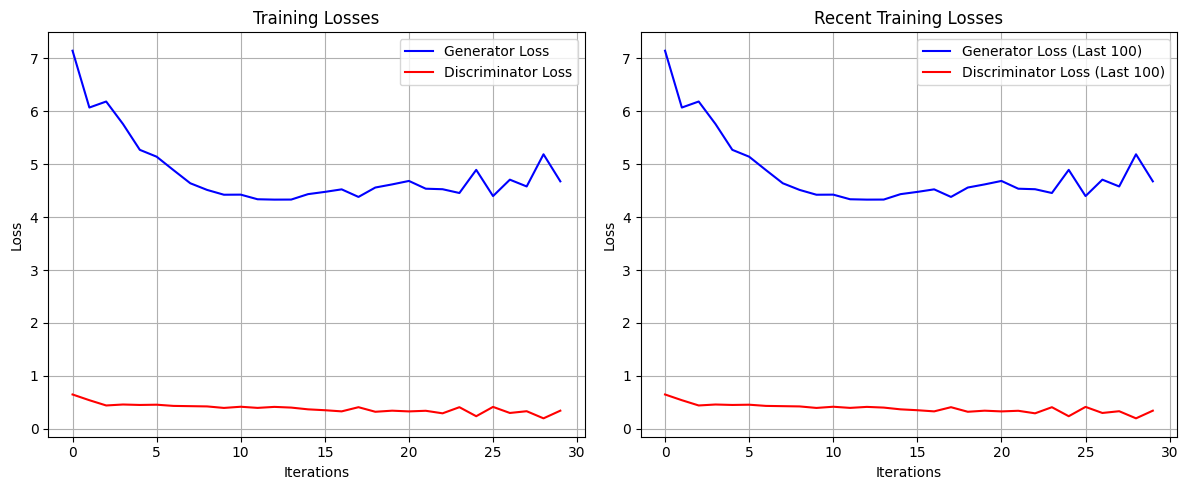

--------------------------------------------------


Epoch 31/50: 100%|██████████| 994/994 [02:07<00:00,  7.77it/s, D_loss=0.1918, G_loss=3.9018]


Epoch [31/50] - G_loss: 4.7424, D_loss: 0.3001


Epoch 32/50: 100%|██████████| 994/994 [02:11<00:00,  7.55it/s, D_loss=0.1851, G_loss=8.8318]


Epoch [32/50] - G_loss: 5.3057, D_loss: 0.1966


Epoch 33/50: 100%|██████████| 994/994 [02:07<00:00,  7.78it/s, D_loss=0.2370, G_loss=3.4878]


Epoch [33/50] - G_loss: 4.5974, D_loss: 0.3467


Epoch 34/50: 100%|██████████| 994/994 [02:04<00:00,  8.01it/s, D_loss=0.0173, G_loss=6.2717]


Epoch [34/50] - G_loss: 4.6890, D_loss: 0.3162


Epoch 35/50: 100%|██████████| 994/994 [02:03<00:00,  8.03it/s, D_loss=0.1880, G_loss=6.0221]


Epoch [35/50] - G_loss: 4.6089, D_loss: 0.3208

--- Generated Samples at Epoch 35 ---


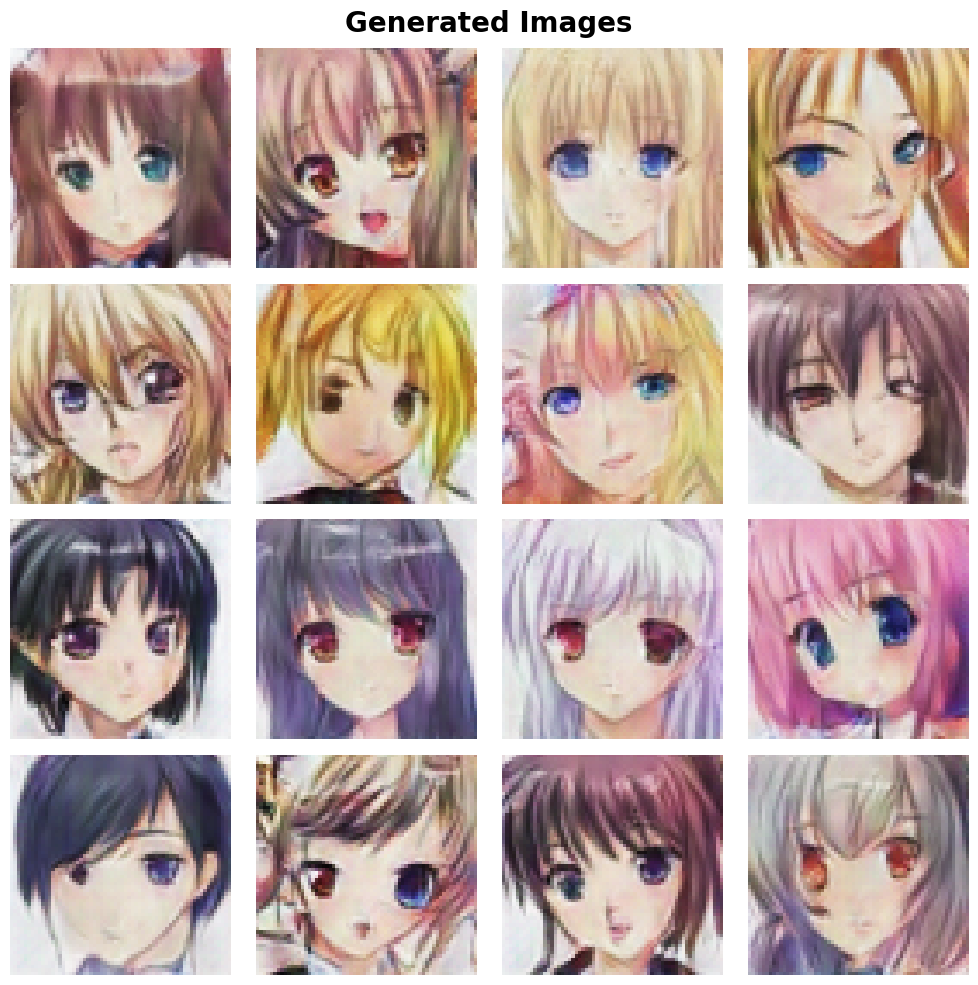

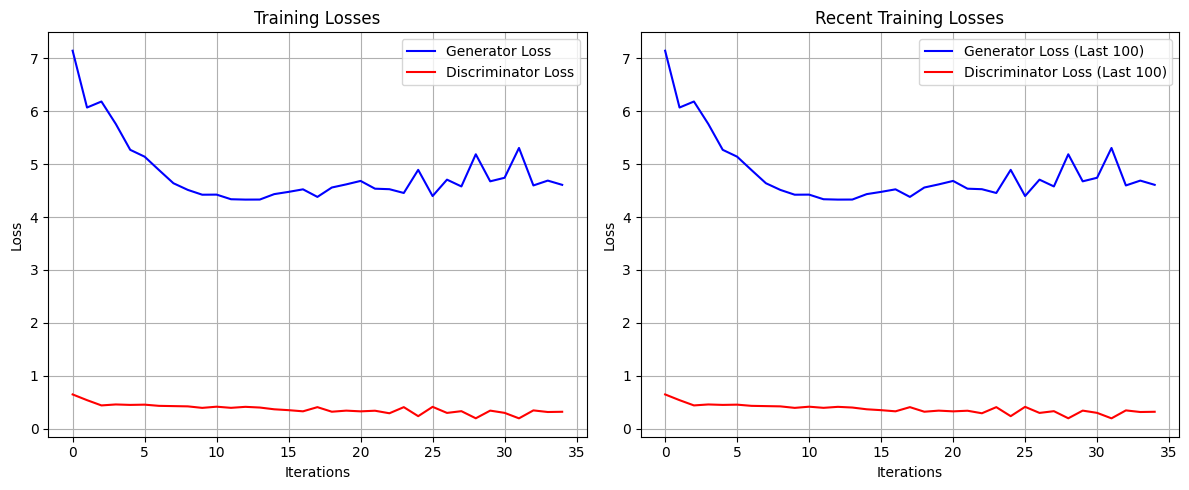

--------------------------------------------------


Epoch 36/50: 100%|██████████| 994/994 [02:08<00:00,  7.71it/s, D_loss=0.1599, G_loss=8.2566]


Epoch [36/50] - G_loss: 4.7779, D_loss: 0.2912


Epoch 37/50: 100%|██████████| 994/994 [02:08<00:00,  7.72it/s, D_loss=0.5273, G_loss=6.2065]


Epoch [37/50] - G_loss: 4.8881, D_loss: 0.2774


Epoch 38/50: 100%|██████████| 994/994 [02:09<00:00,  7.70it/s, D_loss=0.1508, G_loss=3.6278]


Epoch [38/50] - G_loss: 5.0111, D_loss: 0.2314


Epoch 39/50: 100%|██████████| 994/994 [02:08<00:00,  7.71it/s, D_loss=0.0215, G_loss=6.1048]


Epoch [39/50] - G_loss: 5.2879, D_loss: 0.1849


Epoch 40/50: 100%|██████████| 994/994 [02:09<00:00,  7.69it/s, D_loss=0.2646, G_loss=3.1011]


Epoch [40/50] - G_loss: 4.6076, D_loss: 0.3865

--- Generated Samples at Epoch 40 ---


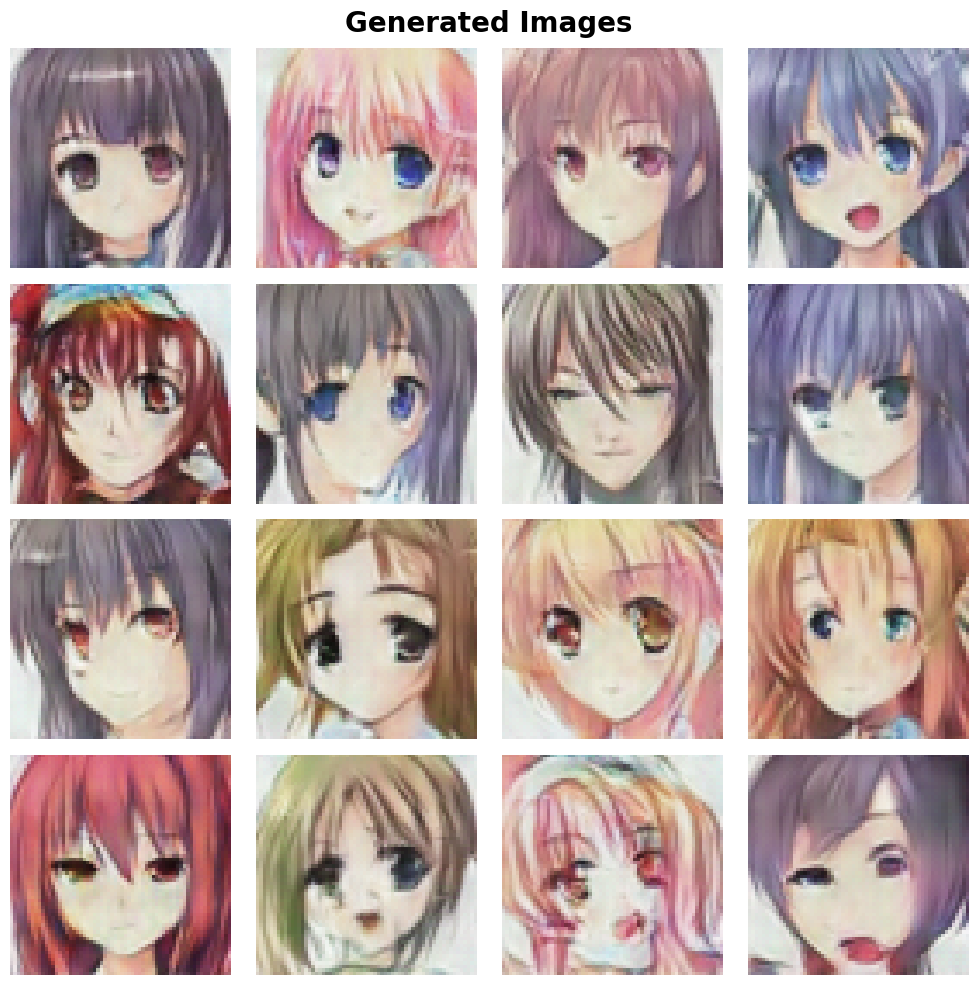

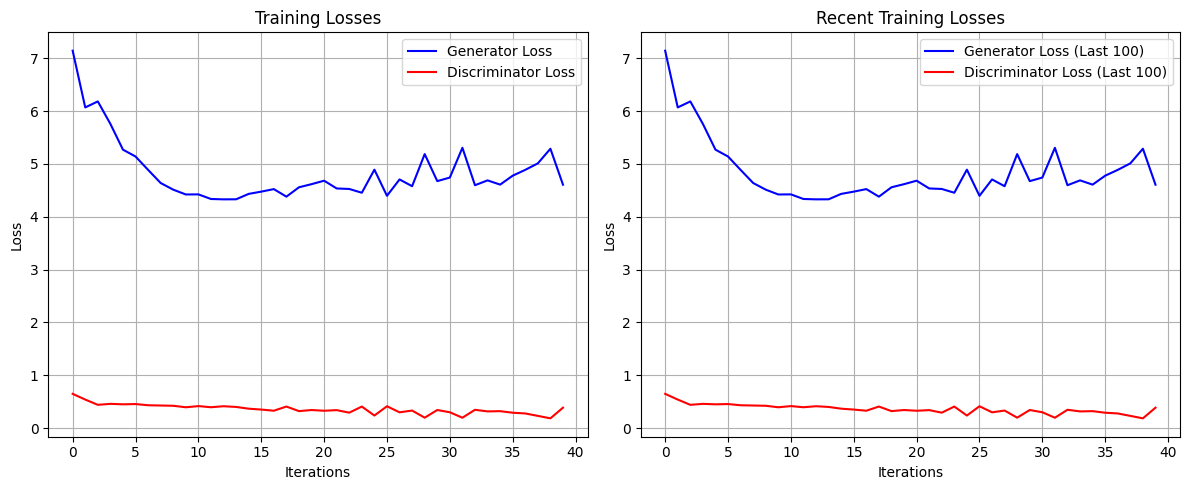

--------------------------------------------------


Epoch 41/50: 100%|██████████| 994/994 [02:11<00:00,  7.56it/s, D_loss=0.0190, G_loss=5.4175]


Epoch [41/50] - G_loss: 4.6913, D_loss: 0.2700


Epoch 42/50: 100%|██████████| 994/994 [02:13<00:00,  7.47it/s, D_loss=0.2775, G_loss=9.1202]


Epoch [42/50] - G_loss: 5.9032, D_loss: 0.1251


Epoch 43/50: 100%|██████████| 994/994 [02:13<00:00,  7.43it/s, D_loss=0.7572, G_loss=1.9480]


Epoch [43/50] - G_loss: 5.0281, D_loss: 0.2843


Epoch 44/50: 100%|██████████| 994/994 [02:12<00:00,  7.51it/s, D_loss=0.0208, G_loss=6.0349]


Epoch [44/50] - G_loss: 4.7405, D_loss: 0.3179


Epoch 45/50: 100%|██████████| 994/994 [02:13<00:00,  7.44it/s, D_loss=1.3781, G_loss=15.9978]


Epoch [45/50] - G_loss: 4.8012, D_loss: 0.2745

--- Generated Samples at Epoch 45 ---


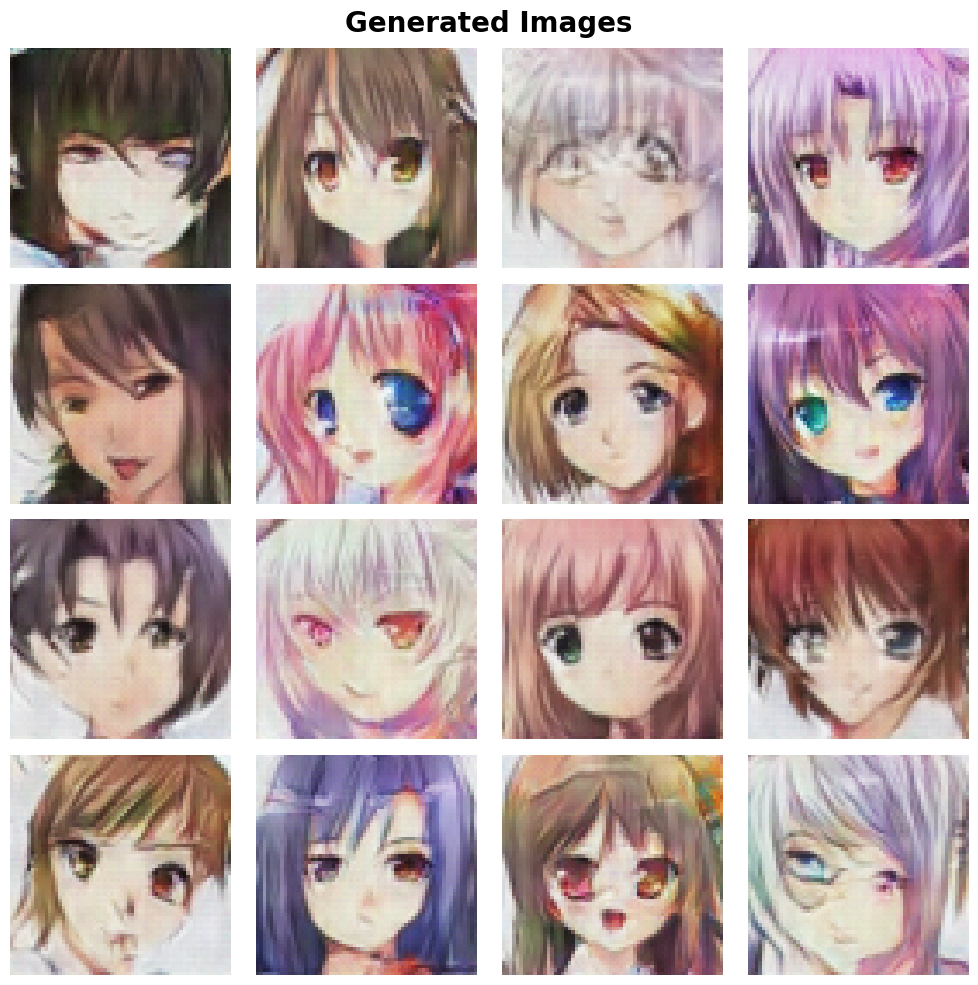

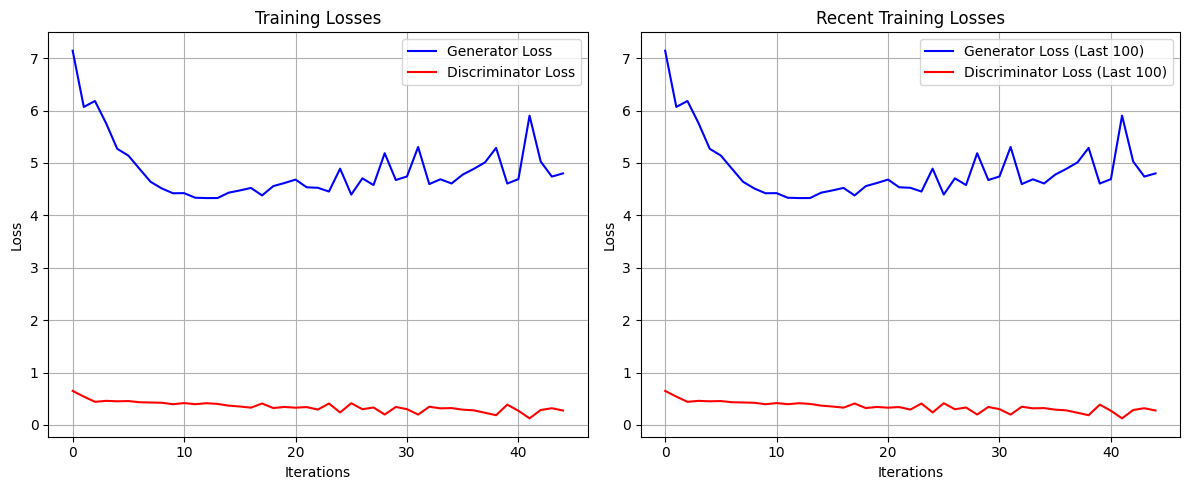

--------------------------------------------------


Epoch 46/50: 100%|██████████| 994/994 [02:16<00:00,  7.29it/s, D_loss=0.2260, G_loss=2.5214]


Epoch [46/50] - G_loss: 4.5384, D_loss: 0.2811


Epoch 47/50: 100%|██████████| 994/994 [02:17<00:00,  7.26it/s, D_loss=0.0537, G_loss=5.5783]


Epoch [47/50] - G_loss: 5.2637, D_loss: 0.1774


Epoch 48/50: 100%|██████████| 994/994 [02:15<00:00,  7.31it/s, D_loss=0.0138, G_loss=5.7313]


Epoch [48/50] - G_loss: 4.8886, D_loss: 0.2911


Epoch 49/50: 100%|██████████| 994/994 [02:16<00:00,  7.27it/s, D_loss=0.0279, G_loss=5.8635]


Epoch [49/50] - G_loss: 5.1388, D_loss: 0.1997


Epoch 50/50: 100%|██████████| 994/994 [02:16<00:00,  7.26it/s, D_loss=0.5672, G_loss=4.5779]


Epoch [50/50] - G_loss: 5.1713, D_loss: 0.2806

--- Generated Samples at Epoch 50 ---


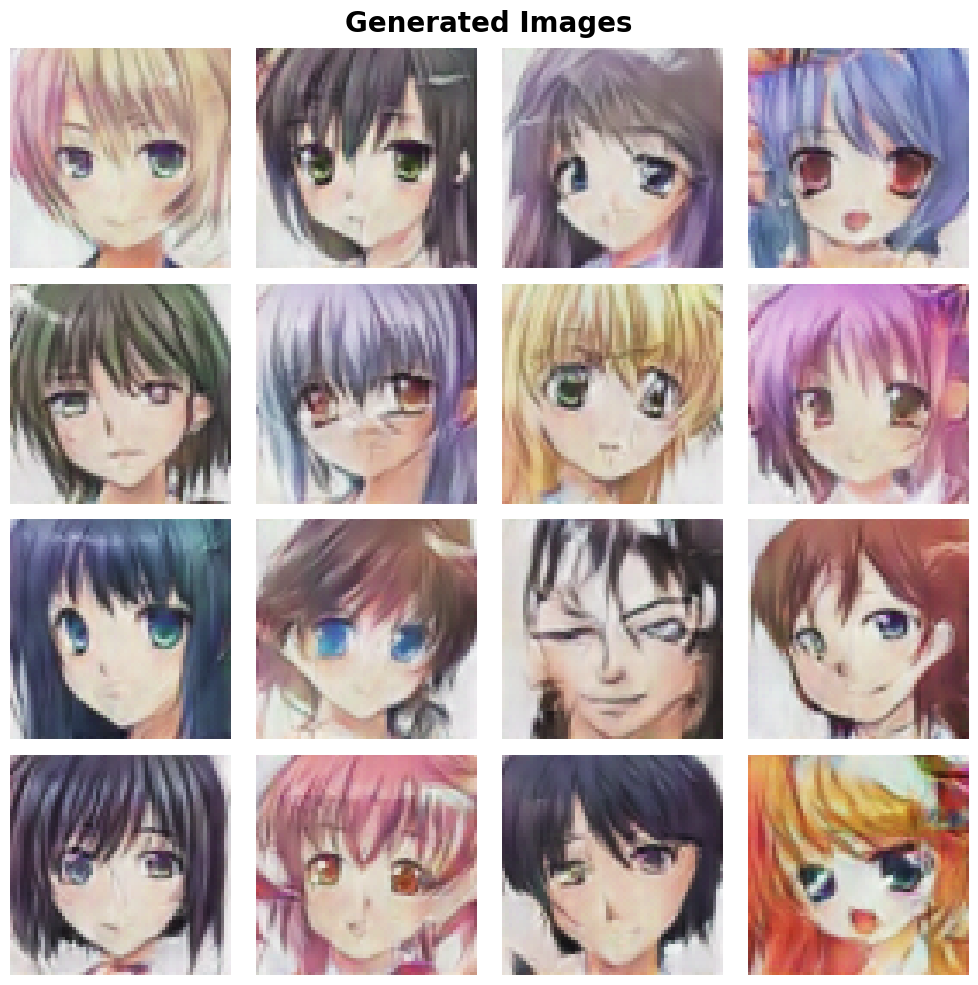

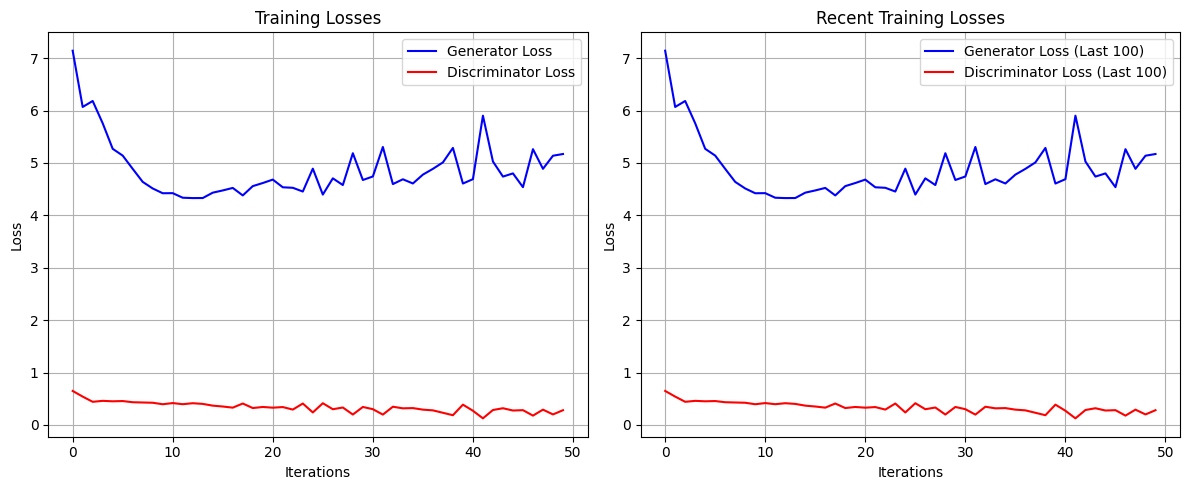

--------------------------------------------------
Training completed!
Training completed!


In [37]:
print("Starting Anime Face GAN Training (PyTorch)!")
print(f"Training with {len(anime_dataset)} images for {EPOCHS} epochs using PyTorch.")

gen_losses, disc_losses = train_gan(
    train_dataloader, generator, discriminator,
    generator_optimizer, discriminator_optimizer, criterion,
    NOISE_DIM, fixed_noise, device
)

print("Training completed!")

In [37]:
# Print Training losses
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Generator & Discriminator Loss over Epochs")
plt.plot(gen_losses, label='Generator Loss', color='blue')
plt.plot(disc_losses, label='Discriminator Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True,alpha=0.3)

plt.subplot(1,2,2)
plt.plot(gen_losses,label="Generator loss",color='blue',linewidth=2)
plt.title("Generator loss",fontsize= 14, fontweight='bold')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True,alpha=0.3)

plt.tight_layout()
plt.show()


In [38]:
# Print final statistics
print("Final Statistics:")
print(f"Average Generator Loss: {gen_losses[-1]:.4f}")
print(f'Final Discriminator loss: {disc_losses[-1]:.4f}')
print(f"Lowest Generator loss:{min(gen_losses):.4f}")

Final Statistics:
Average Generator Loss: 5.1713
Final Discriminator loss: 0.2806
Lowest Generator loss:4.3300


Generating final anime faces (PyTorch)...


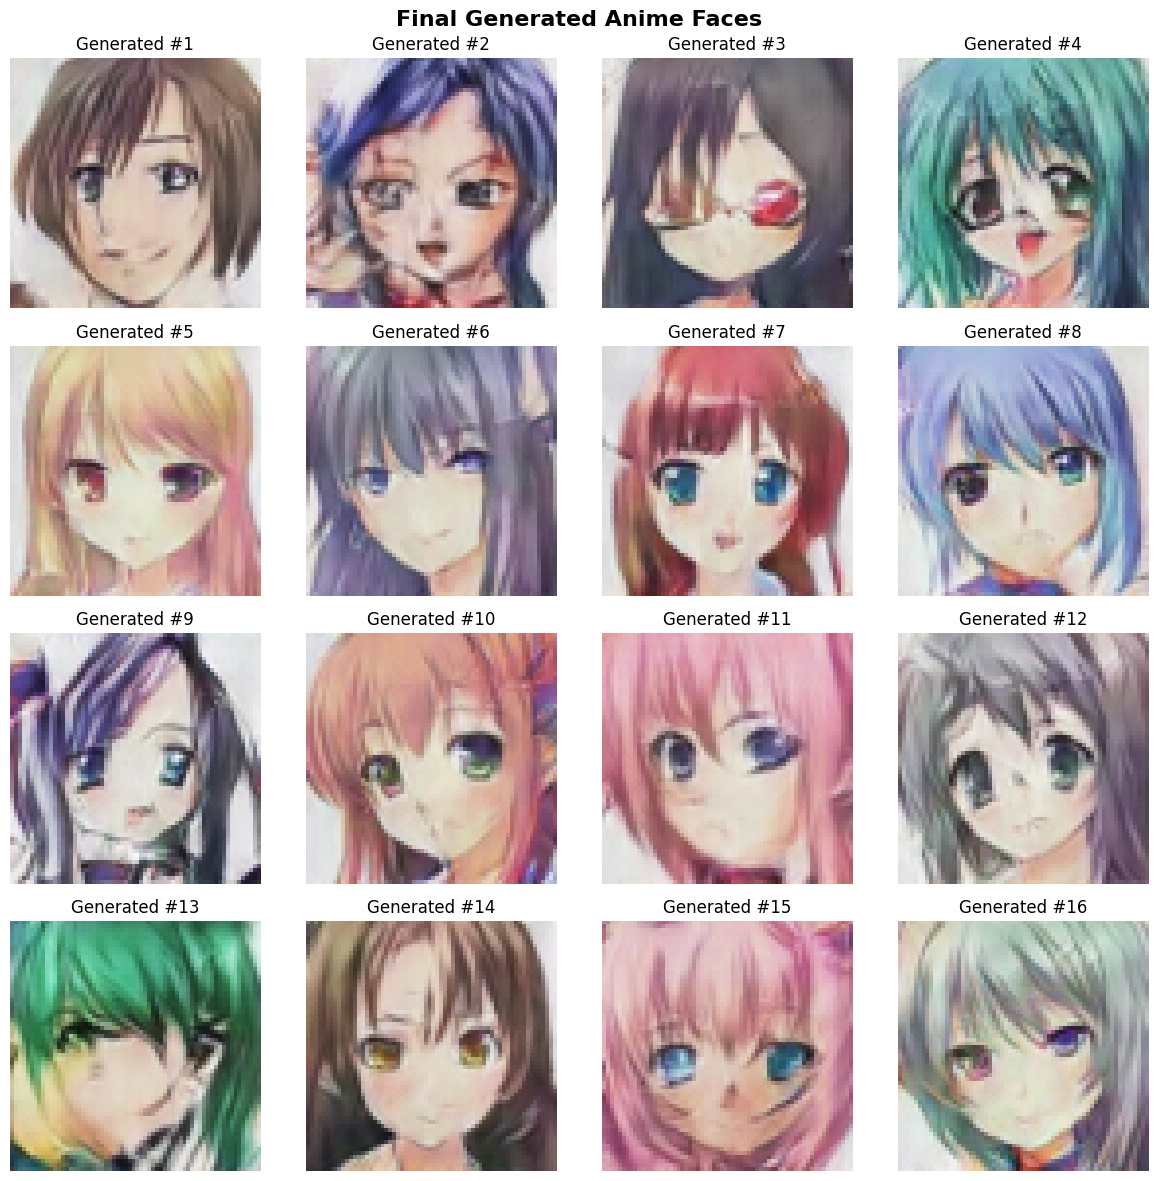

In [39]:
# Generate final images with the trained model
print("Generating final anime faces (PyTorch)...")
final_seed = torch.randn(16, NOISE_DIM, 1, 1, device=device)
generator.eval()
with torch.no_grad():
    final_generated_images = generator(final_seed).cpu()
generator.train()

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Final Generated Anime Faces', fontsize=16, fontweight='bold')
for i, ax in enumerate(axes.flat):
    img = final_generated_images[i] * 0.5 + 0.5 # Denormalize
    img = torch.clamp(img, 0.0, 1.0)
    ax.imshow(img.permute(1, 2, 0).numpy()) # C,H,W to H,W,C
    ax.set_title(f'Generated #{i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

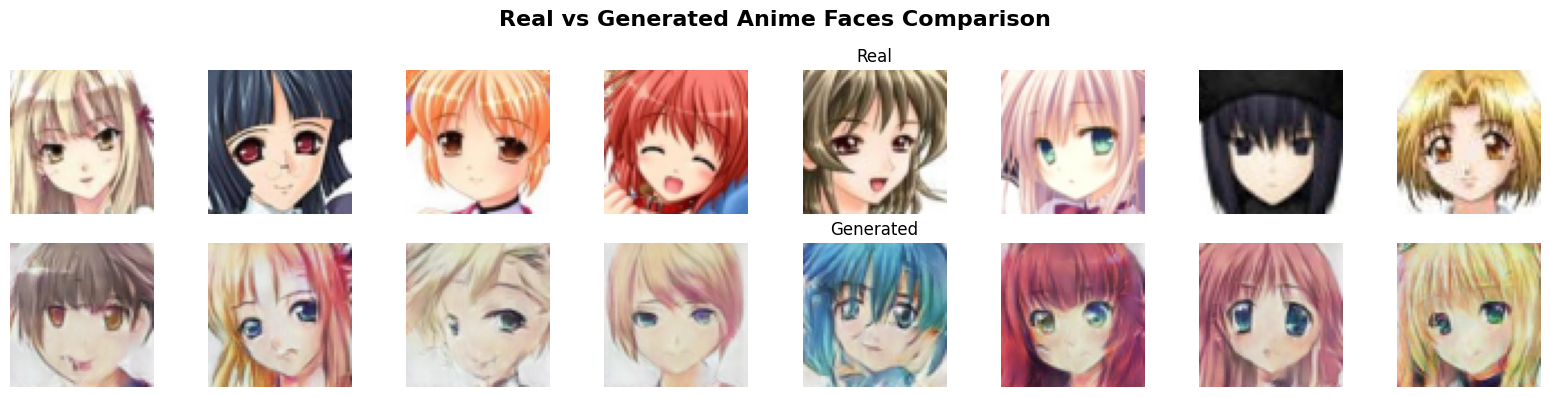

In [40]:
def compare_real_vs_generated(dataloader, model_G, num_comparisons=8):
    """Compare real and generated images side by side"""
    # Get real images
    real_batch = next(iter(dataloader))
    real_images = real_batch[:num_comparisons].to(device if device.type != 'mps' else 'cpu')

    # Generate fake images - ADD THE MISSING DIMENSIONS
    noise = torch.randn(num_comparisons, NOISE_DIM, 1, 1, device=device)  # Changed this line
    model_G.eval()
    with torch.no_grad():
        generated_images = model_G(noise).cpu() # Generate and move to CPU
    model_G.train()

    fig, axes = plt.subplots(2, num_comparisons, figsize=(16, 4))
    fig.suptitle('Real vs Generated Anime Faces Comparison', fontsize=16, fontweight='bold')

    for i in range(num_comparisons):
        # Real images
        real_img_processed = real_images[i] * 0.5 + 0.5
        real_img_processed = torch.clamp(real_img_processed, 0.0, 1.0)
        axes[0, i].imshow(real_img_processed.cpu().permute(1, 2, 0).numpy()) # Move to CPU if not already
        axes[0, i].set_title('Real' if i == num_comparisons//2 else '')
        axes[0, i].axis('off')

        # Generated images
        gen_img_processed = generated_images[i] * 0.5 + 0.5
        gen_img_processed = torch.clamp(gen_img_processed, 0.0, 1.0)
        axes[1, i].imshow(gen_img_processed.permute(1, 2, 0).numpy()) # Already on CPU
        axes[1, i].set_title('Generated' if i == num_comparisons//2 else '')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Perform comparison
compare_real_vs_generated(train_dataloader, generator)


In [41]:
torch.save(generator.state_dict(), 'anime_face_generator_pytorch.pth')
print("Generator model saved as 'anime_face_generator_pytorch.pth'")

Generator model saved as 'anime_face_generator_pytorch.pth'


In [42]:
print(f'Final Generator Loss: {gen_losses[-1]:.4f}')
print(f'Final Discriminator Loss: {disc_losses[-1]:.4f}')
print(f'Training Dataset Size: {dataset_size:,} images')

Final Generator Loss: 5.1713
Final Discriminator Loss: 0.2806
Training Dataset Size: 63,565 images
